In [1]:
# import numpy as np
# import os
# import pandas as pd
# import geopandas as gpd
# import xarray as xr
# import rioxarray
# from matplotlib import pyplot as plt
# import seaborn as sns
import codebase
from codebase import ml_pipeline

In [41]:
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector

- upstream of Lake Powell (San Juan River trib): 4152600
- Lee's Ferry: 4152450
- below Hoover Dam: 4152103
- US-Mexico border: 4152050

In [2]:
input_combos = [('Powell', 'glen canyon', 4152600),
                ('Powell', 'glen canyon', 4152450),
                ('Mead', 'hoover', 4152103),
                ('Mead', 'hoover', 4152050)]

In [3]:
res_name , dam_name, grdc_id = input_combos[3]

n_epochs = 300

In [4]:
all_data = ml_pipeline.LSTM_preprocessing(res_name = res_name,
                                          dam_name = dam_name,
                                          grdc_id = grdc_id)

ERROR 1: PROJ: proj_create_from_database: Open of /global/home/users/ann_scheliga/.conda/envs/rio_keras/share/proj failed


Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Projected to equal area
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Projected to equal area


<Axes: >

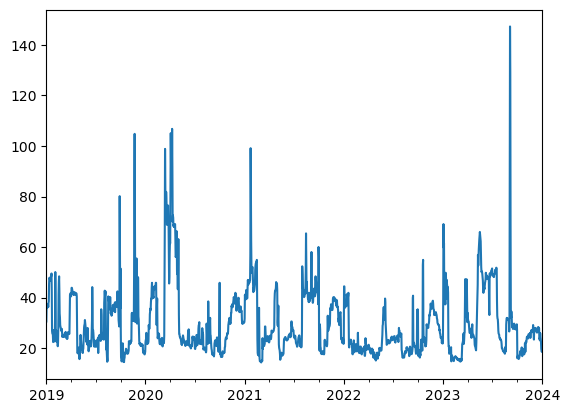

In [6]:
all_data['Q m3s'].plot()

In [45]:
X_train, X_test, y_train, y_test = ml_pipeline.split_data_and_reshape(all_data[:-1])
X_met_train, X_met_test =ml_pipeline.met_split(X_train, X_test)

X train shape: (1, 910, 3); y train shape: (1, 910, 1)
X test shape: (1, 910, 3); y test shape: (1, 910, 1)


In [46]:
n_timesteps_in = X_train.shape[-2]
n_features = X_train.shape[-1]
n_timesteps_out = 1

In [47]:
def make_LSTM_1layer_model(n_timesteps_in: int, n_features: int) -> Model:
    """
    Create a keras model.
    Stores the model as a function, so all experiments get the same model.
    """
    from tensorflow.keras import Input
    from tensorflow.keras.layers import (
        LSTM,
        Dense,
        RepeatVector,
    )
    from tensorflow.keras.models import Sequential

    model = Sequential()
    model.add(Input(shape=(n_timesteps_in, n_features)))
    model.add(LSTM(150, dropout=0.2))
    model.add(Dense(n_timesteps_in, activation="relu"))
    model.compile(
        loss="MeanSquaredError", optimizer="adam", metrics=["MeanAbsoluteError"]
    )
    print(model.summary())
    return model

In [48]:
model_nw = make_LSTM_1layer_model(n_timesteps_in,2)
model_nw_history = model_nw.fit(X_met_train, y_train, epochs=n_epochs, batch_size=38,validation_data=(X_met_test, y_test))

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 150)            │        91,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 910)            │       137,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,210 (895.35 KB)

 Trainable params: 229,210 (895.35 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - MeanAbsoluteError: 30.9088 - loss: 1163.5737 - val_MeanAbsoluteError: 28.4716 - val_loss: 961.0009
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - MeanAbsoluteError: 31.0090 - loss: 1169.6039 - val_MeanAbsoluteError: 28.4578 - val_loss: 960.2297
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - MeanAbsoluteError: 30.8748 - loss: 1161.5031 - val_MeanAbsoluteError: 28.4408 - val_loss: 959.2775
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - MeanAbsoluteError: 30.8580 - loss: 1160.4791 - val_MeanAbsoluteError: 28.4222 - val_loss: 958.2404
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - MeanAbsoluteError: 30.8398 - loss: 1159.3704 - val_MeanAbsoluteError: 28.4026 - val_loss: 957.1449
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - MeanAbsoluteError: 30.8206 - loss: 1158.2043 - val_MeanAbsoluteError: 28.3821 - val_loss: 956.0032
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - MeanAbsoluteError: 31.0025 - loss

In [49]:
model_sw = make_LSTM_1layer_model(n_timesteps_in, 3)
model_sw_history = model_sw.fit(X_train, y_train, epochs=n_epochs, batch_size=38,validation_data=(X_test, y_test))

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 150)            │        92,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 910)            │       137,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,810 (897.70 KB)

 Trainable params: 229,810 (897.70 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - MeanAbsoluteError: 30.9126 - loss: 1163.6697 - val_MeanAbsoluteError: 28.4928 - val_loss: 962.0367
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - MeanAbsoluteError: 30.9102 - loss: 1163.5278 - val_MeanAbsoluteError: 28.4782 - val_loss: 961.2135
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - MeanAbsoluteError: 30.9046 - loss: 1163.0682 - val_MeanAbsoluteError: 28.4640 - val_loss: 960.4118
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - MeanAbsoluteError: 30.8814 - loss: 1161.6482 - val_MeanAbsoluteError: 28.4469 - val_loss: 959.4421
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - MeanAbsoluteError: 30.8637 - loss: 1160.5090 - val_MeanAbsoluteError: 28.4276 - val_loss: 958.3469
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - MeanAbsoluteError: 30.8503 - loss: 1159.8970 - val_MeanAbsoluteError: 28.4106 - val_loss: 957.3824
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - MeanAbsoluteError: 30.8378 - loss

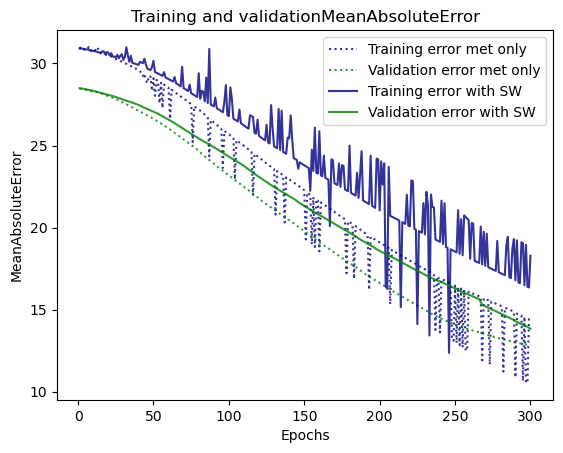

In [50]:
ml_pipeline.compare_epoch_error(model_nw_history.history,model_sw_history.history,fig_name='border_1layer_MAE')

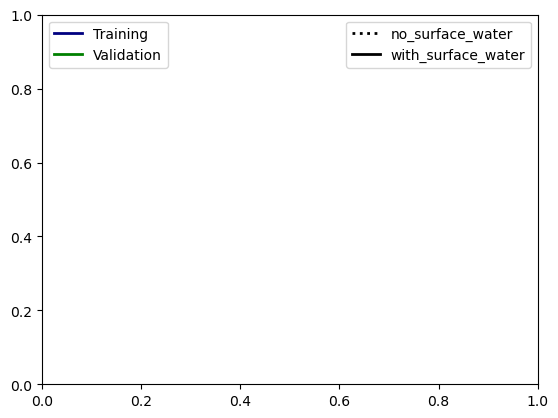

In [51]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

color_lines = [Line2D([0], [0], color='navy', lw=2),
                Line2D([0], [0], color='green', lw=2)]
style_lines = [Line2D([0], [0], color='black',linestyle=':', lw=2),
                Line2D([0], [0], color='black',linestyle='-', lw=2)]
fig, ax = plt.subplots()
color_legend = plt.legend(color_lines, ['Training', 'Validation'],loc='upper left')
ax.legend(style_lines, ['no_surface_water', 'with_surface_water'],loc='upper right')
plt.gca().add_artist(color_legend)